In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False):

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        dataset = datasets.CIFAR10(
          root=data_dir, train=False,
          download=True, transform=transform,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


# CIFAR10 dataset
train_loader, valid_loader = data_loader(data_dir='./data',
                                         batch_size=64)

test_loader = data_loader(data_dir='./data',
                              batch_size=64,
                              test=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 28656174.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Choose between different normalization layers
def get_normalization_layer(normalization_technique, num_channels):
    if normalization_technique == 'batch':
        return nn.BatchNorm2d(num_channels)
    elif normalization_technique == 'group':
        return nn.GroupNorm(8, num_channels)  # You can adjust the number of groups
    elif normalization_technique == 'instance':
        return nn.InstanceNorm2d(num_channels)
    elif normalization_technique == 'layer':
        return nn.LayerNorm(num_channels)
    else:
        raise ValueError("Invalid normalization technique")

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        get_normalization_layer(normalization_technique,out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        get_normalization_layer(normalization_technique,out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10, normalization_technique='batch'):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        get_normalization_layer(normalization_technique, 64),  # Use selected normalization,
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                get_normalization_layer(normalization_technique, planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [6]:
num_classes = 10
num_epochs = 5
batch_size = 16
learning_rate = 0.01
normalization_techniques = ['instance', 'batch', 'group']
accuracies = []

Technique: instance
Epoch [1/5], Loss: 1.1289
Accuracy of the network on the 5000 validation images: 48.46 %
Epoch [2/5], Loss: 0.4674
Accuracy of the network on the 5000 validation images: 68.28 %
Epoch [3/5], Loss: 0.3575
Accuracy of the network on the 5000 validation images: 73.22 %
Epoch [4/5], Loss: 0.1949
Accuracy of the network on the 5000 validation images: 80.64 %
Epoch [5/5], Loss: 0.5349
Accuracy of the network on the 5000 validation images: 81.36 %
Technique: batch
Epoch [1/5], Loss: 1.5678
Accuracy of the network on the 5000 validation images: 56.06 %
Epoch [2/5], Loss: 0.2370
Accuracy of the network on the 5000 validation images: 73.08 %
Epoch [3/5], Loss: 1.0048
Accuracy of the network on the 5000 validation images: 77.42 %
Epoch [4/5], Loss: 0.8714
Accuracy of the network on the 5000 validation images: 79.58 %
Epoch [5/5], Loss: 0.6251
Accuracy of the network on the 5000 validation images: 81.58 %
Technique: group
Epoch [1/5], Loss: 2.2585
Accuracy of the network on the

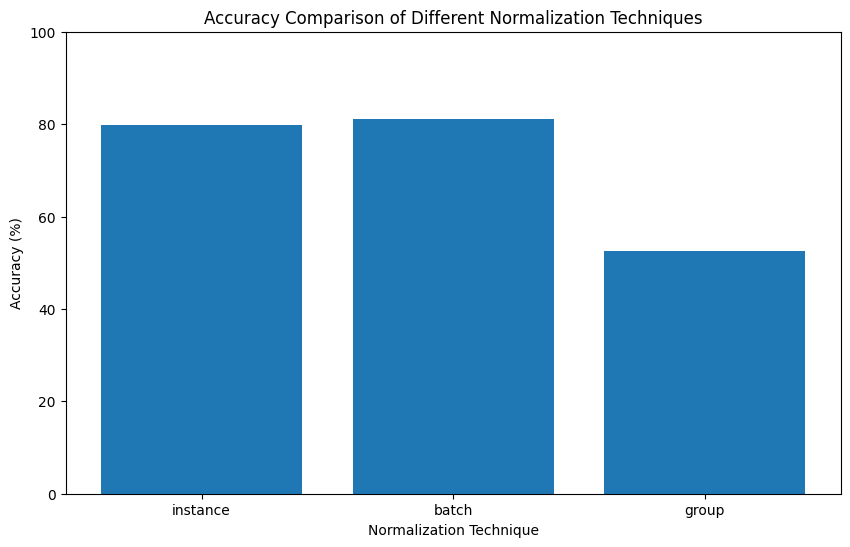

In [7]:
for normalization_technique in normalization_techniques:
    print("Technique: " + normalization_technique)
    model = ResNet(ResidualBlock, [3, 4, 6, 3], normalization_technique=normalization_technique).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    total_step = len(train_loader)
    import gc
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

        print ('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, loss.item()))

        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs

            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        accuracy = 100 * correct / total
        accuracies.append(accuracy)

# Plotting the accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(normalization_techniques, accuracies)
plt.xlabel('Normalization Technique')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different Normalization Techniques')
plt.ylim(0, 100)
plt.show()